## Create Decision Tree Model to Forecast Returns

#### Import Packages

In [1]:
import pandas as pd
import datetime
import gc
from sklearn.ensemble import (
BaggingRegressor, RandomForestRegressor, AdaBoostRegressor)
from sklearn.metrics import mean_squared_error
from technical_indicators import * # import all function
from sklearn.model_selection import TimeSeriesSplit
#import parfit as pf
from sklearn.metrics import r2_score
import numpy as np
from sklearn.model_selection import ParameterGrid
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from sklearn import linear_model

#### Read in Data via GitHub URL

In [2]:
url = "https://raw.githubusercontent.com/meenmo/Stat479_Project/master/Data/IBM.csv"
df_ORIGINAL = pd.read_csv(url)

***
## Clean Data & Create Technical Indicator Variables

- Create Deep copy of dataframe
- Use Adjusted Close Data
- Drop Close 
- Rename "Adj. Close" as "Close"

In [3]:
df_features = df_ORIGINAL.copy(deep=True) # Create Deep
df_features.drop(['Close'], axis = 1, inplace = True) # drop close column
df_features.columns = ['Date', 'High', 'Low', 'Open', 'Volume', 'Close'] # Close is actually Adj. Close

df_features['Date'] = pd.to_datetime(df_features['Date'])
df_features.head() # sanity check

,Date,High,Low,Open,Volume,Close
0,2002-01-02,121.500000,119.800003,120.599999,6862800,84.677422
1,2002-01-03,124.220001,120.250000,121.500000,8621700,86.182800
2,2002-01-04,125.599999,123.980003,124.050003,8405200,87.534859
3,2002-01-07,126.190002,123.699997,125.000000,5939600,86.454575
4,2002-01-08,125.199997,123.730003,124.250000,5311800,86.907600


#### Function: Create Lagged Returns

In [4]:
"""
Creates Lagged Returns 
- given OHLCV dataframe
- numer of lagged days
"""
def create_lag_features(df, lag_days):
    df_ret = df.copy()
    
    # iterate through the lag days to generate lag values up to lag_days + 1
    for i in range(1,lag_days + 2):
        df_lag = df_ret[['Date', 'Close']].copy()
        # generate dataframe to shift index by i day.
        df_lag['Date'] = df_lag['Date'].shift(-i)
        df_lag.columns = ['Date', 'value_lag' + str(i)]
        # combine the valuelag
        df_ret = pd.merge(df_ret, df_lag, how = 'left', left_on = ['Date'], right_on = ['Date'])
    
    #frees memory
    del df_lag
    
    # calculate today's percentage lag
    df_ret['Today'] = (df_ret['Close'] - df_ret['value_lag1'])/(df_ret['value_lag1']) * 100.0 
    
    # calculate percentage lag
    for i in range(1, lag_days + 1):
        df_ret['lag' + str(i)] = (df_ret['value_lag'+ str(i)] - df_ret['value_lag'+ str(i+1)])/(df_ret['value_lag'+str(i+1)]) * 100.0
    
    # drop unneeded columns which are value_lags
    for i in range(1, lag_days + 2):
        df_ret.drop(['value_lag' + str(i)], axis = 1, inplace = True)
                                                                                                                                                                                                                                                                                                                                     
    return df_ret


### Run Function
df_features = create_lag_features(df_features, 5) # 5 lag features
df_features.head(7)

,Date,High,Low,Open,Volume,Close,Today,lag1,lag2,lag3,lag4,lag5
0,2002-01-02,121.500000,119.800003,120.599999,6862800,84.677422,NaN,NaN,NaN,NaN,NaN,NaN
1,2002-01-03,124.220001,120.250000,121.500000,8621700,86.182800,1.777781,NaN,NaN,NaN,NaN,NaN
2,2002-01-04,125.599999,123.980003,124.050003,8405200,87.534859,1.568826,1.777781,NaN,NaN,NaN,NaN
3,2002-01-07,126.190002,123.699997,125.000000,5939600,86.454575,-1.234119,1.568826,1.777781,NaN,NaN,NaN
4,2002-01-08,125.199997,123.730003,124.250000,5311800,86.907600,0.524004,-1.234119,1.568826,1.777781,NaN,NaN
5,2002-01-09,126.389999,124.150001,124.699997,6839900,86.761269,-0.168376,0.524004,-1.234119,1.568826,1.777781,NaN
6,2002-01-10,124.000000,121.419998,123.750000,8926300,85.123428,-1.887755,-0.168376,0.524004,-1.234119,1.568826,1.777781


#### Drop Rows with NaN

In [5]:
# drop earlier data with missing lag features
df_features.dropna(inplace=True)
# reset index
df_features.reset_index(drop = True, inplace = True)

#### Create Technical Indicators

- Create Technical Indicators
- Call functions from `technical_inicators.py`
- Drop Rows with NaN
  

In [6]:
#### GENERATE TECHNICAL INDICATORS FEATURES
df_features = standard_deviation(df_features, 14)

df_features = relative_strength_index(df_features, 14) # periods
df_features = average_directional_movement_index(df_features, 14, 13) # n, n_ADX
df_features = moving_average(df_features, 21) # periods
df_features = exponential_moving_average(df_features, 21) # periods
df_features = momentum(df_features, 14) # 

df_features = average_true_range(df_features, 14)
df_features = bollinger_bands(df_features, 21)
df_features = ppsr(df_features)
df_features = stochastic_oscillator_k(df_features)
df_features = stochastic_oscillator_d(df_features, 14)
df_features = trix(df_features, 14)
df_features = macd(df_features, 26, 12)
df_features = mass_index(df_features)
df_features = vortex_indicator(df_features, 14)

df_features = kst_oscillator(df_features, 10, 10, 10, 15, 10, 15, 20, 30)
df_features = true_strength_index(df_features, 25, 13)

#df_features = accumulation_distribution(df_features, 14) # Causes Problems, apparently
df_features = chaikin_oscillator(df_features)
df_features = money_flow_index(df_features, 14)
df_features = on_balance_volume(df_features, 14)
df_features = force_index(df_features, 14)
df_features = ease_of_movement(df_features, 14)
df_features = commodity_channel_index(df_features, 14)
df_features = keltner_channel(df_features, 14)
df_features = ultimate_oscillator(df_features)
df_features = donchian_channel(df_features, 14)
    
# drop earlier data with missing lag features
df_features.dropna(inplace=True)
df_features = df_features.reset_index(drop = True)

In [7]:
# Re-set "Date" as the index
df_features = df_features.set_index('Date')

### Sanity Check
df_features.head(10)

,High,Low,Open,Volume,Close,Today,lag1,lag2,lag3,lag4,...,MFI_14,OBV_14,Force_14,EoM_14,CCI_14,KelChM_14,KelChU_14,KelChD_14,Ultimate_Osc,Donchian_14
Date,,,,,,,,,,,,,,,,,,,,,
2002-03-14,107.949997,106.589996,107.019997,5335500,74.391068,-0.541176,-1.216580,3.097695,0.142742,1.330632,...,0.714286,1.962464e+06,-2.921157e+07,2.286739e-07,0.959960,93.032764,95.832764,90.232765,0.034641,13.389999
2002-03-15,107.449997,105.589996,106.550003,10864100,74.523666,0.178246,-0.541176,-1.216580,3.097695,0.142742,...,0.642857,3.445814e+06,5.695471e+06,2.086708e-07,0.713277,93.570735,96.351449,90.790020,0.031385,13.389999
2002-03-18,108.639999,106.230003,107.099999,5301200,74.216637,-0.411990,0.178246,-0.541176,-1.216580,3.097695,...,0.714286,3.898193e+06,-4.066156e+07,2.500726e-07,0.779588,94.192408,96.916693,91.468123,0.058735,13.389999
2002-03-19,108.050003,106.489998,106.849999,4614800,75.012154,1.071885,-0.411990,0.178246,-0.541176,-1.216580,...,0.714286,3.372200e+06,-4.964177e+07,2.263920e-07,0.762796,94.770295,97.348152,92.192438,0.057835,13.389999
2002-03-20,106.900001,105.489998,106.900001,4844100,73.623466,-1.851283,1.071885,-0.411990,0.178246,-0.541176,...,0.642857,2.459121e+06,-1.593928e+07,2.007584e-07,0.060704,95.249347,97.800775,92.697918,0.026201,13.389999
2002-03-21,106.779999,104.699997,105.699997,5113100,74.516685,1.213226,-1.851283,1.071885,-0.411990,0.178246,...,0.571429,2.074850e+06,-1.411611e+07,1.220918e-07,-0.248791,95.547059,97.918488,93.175630,-0.008129,13.389999
2002-03-22,106.699997,105.070000,106.500000,5507900,73.693192,-1.105114,1.213226,-1.851283,1.071885,-0.411990,...,0.500000,9.123071e+05,1.101343e+06,3.426329e-08,-0.533297,95.592311,97.837311,93.347311,-0.021320,13.389999
2002-03-25,106.660004,103.500000,105.800003,6277900,72.269615,-1.931761,-1.105114,1.213226,-1.851283,1.071885,...,0.428571,1.004036e+06,1.890940e+06,-5.730833e-09,-1.582313,95.545348,97.848920,93.241776,-0.045311,13.389999
2002-03-26,105.699997,102.300003,103.570000,8144000,71.809052,-0.637285,-1.931761,-1.105114,1.213226,-1.851283,...,0.357143,-1.267786e+05,-1.083363e+06,-5.076478e-08,-1.978289,95.397427,97.776713,93.018141,-0.061006,11.739998


#### Create Future Returns

In [8]:
df_features['Future Returns'] = df_features['Today'].shift(-1) 

# drop earlier data with missing lag features
df_features.dropna(inplace=True)

df_features.head()

,High,Low,Open,Volume,Close,Today,lag1,lag2,lag3,lag4,...,OBV_14,Force_14,EoM_14,CCI_14,KelChM_14,KelChU_14,KelChD_14,Ultimate_Osc,Donchian_14,Future Returns
Date,,,,,,,,,,,,,,,,,,,,,
2002-03-14,107.949997,106.589996,107.019997,5335500,74.391068,-0.541176,-1.216580,3.097695,0.142742,1.330632,...,1.962464e+06,-2.921157e+07,2.286739e-07,0.959960,93.032764,95.832764,90.232765,0.034641,13.389999,0.178246
2002-03-15,107.449997,105.589996,106.550003,10864100,74.523666,0.178246,-0.541176,-1.216580,3.097695,0.142742,...,3.445814e+06,5.695471e+06,2.086708e-07,0.713277,93.570735,96.351449,90.790020,0.031385,13.389999,-0.411990
2002-03-18,108.639999,106.230003,107.099999,5301200,74.216637,-0.411990,0.178246,-0.541176,-1.216580,3.097695,...,3.898193e+06,-4.066156e+07,2.500726e-07,0.779588,94.192408,96.916693,91.468123,0.058735,13.389999,1.071885
2002-03-19,108.050003,106.489998,106.849999,4614800,75.012154,1.071885,-0.411990,0.178246,-0.541176,-1.216580,...,3.372200e+06,-4.964177e+07,2.263920e-07,0.762796,94.770295,97.348152,92.192438,0.057835,13.389999,-1.851283
2002-03-20,106.900001,105.489998,106.900001,4844100,73.623466,-1.851283,1.071885,-0.411990,0.178246,-0.541176,...,2.459121e+06,-1.593928e+07,2.007584e-07,0.060704,95.249347,97.800775,92.697918,0.026201,13.389999,1.213226


***
## Train-Test Split

#### (Subject to change depending)
-  Train     : 2002 - 2017
    -  Validation: 2015 - 2017
    - OR         : Time Series Validation from the website
-  Test      : 2018 - Oct 31, 2018

#### In this Notebook
- Train : 2002 - 2017
- Test  : 2018 - Oct 31, 2018


#### Note
- y is Todays Daily Return.
- We wan't to PREDICT Tomorrows Daily Return
- Hence, we train the model on data __[start, today]__ and __predict y[today + 1]__ and NOT predict y[today]




In [63]:
#str(df_features)

In [9]:

### Old
##########################################################################################
# # do time series split DOING NUMBER 2
# splits = TimeSeriesSplit(n_splits=5)

# # this is unnecessary because you just drop it later anyways...
# # df_features['Future Returns'] = df_features['Today'].shift(-1) 

# # stores all labels
# # y = df_features['Today']
# y = df_features['Today'].shift(-1) # tomorrows returns

# # ### Do not need to drop. Just don't use tomorrows data to predict tomorrows prices.
# # ### Hence, only use todays data to predict tomorrows prices
# # # drop unneded columns
# #df_features.drop(['Open','Close','Low','High','Today'], axis = 1, inplace = True)

# # # all training data
# X_train_all = df_features.loc[(df_features['Date'] < '2018-01-01')]
# y_train_all = y[X_train_all.index]

# # # creates all test data which is all after January 2018
# X_test = df_features.loc[(df_features['Date'] >= '2018-01-01'),:]
# y_test = y[X_test.index]
##########################################################################################

# Predictions --> y == Tomorrows Returns
y = df_features['Future Returns']
df_features.drop(['Future Returns'], axis = 1, inplace = True) # remove Future Returns column

# all training data
X_train_all = df_features.loc[df_features.index < '2018-01-01']
y_train_all = y[X_train_all.index]

# creates all test data which is all after January 2018
X_test = df_features.loc[(df_features.index >= '2018-01-01'),:]
y_test = y[X_test.index]


print("Shape - X_train_all: ", X_train_all.shape)
print("Shape - y_train_all: ", y_train_all.shape)
print("Shape - X_test:      ", X_test.shape)
print("Shape - y_test:      ", y_test.shape)


Shape - X_train_all:  (3979, 48)
Shape - y_train_all:  (3979,)
Shape - X_test:       (210, 48)
Shape - y_test:       (210,)


### Train-Validation Split & Train Models

##### Run Models
- Random Forest
- Bagging
- Boosting
- Linear Regression

##### NOTE
- Need to retrain the model for each prediction. Suppose 200 Days total.
- Hence,
   - Train_1[start date, 100] --> Predict y[101]
   - Train_2[start date, 101] --> Predict y[102]
   - Train_3[start date, 103] --> Predict y[103]
   - ...
   - Train_199[start date, 198] --> Predict y[199]
   - Train_200[start date, 199] --> Predict y[200]
- Thus, to forecast 200 daily returns we need to train 200 different models!!!
   


#### Meenmo's Code

In [110]:
# Initialize empty arrays
trainsamples  = [] # [664, 1327, 1990, 2653, 3316] # sizes of training samples
model1metrics = [] # Random Forest
model2metrics = [] # Bagging
model3metrics = [] # Boosting
model4metrics = [] # Linear Regression

In [43]:
a=len(df_features.loc[df_features.index < '2015-01-01'])
b=len(df_features.loc[df_features.index < '2018-01-01'])

In [111]:
for i in list(range(b-a)):
    X_train = X_train_all.iloc[:a+i,:]
    y_train = y_train_all.iloc[:a+i]
    
    X_val = X_train_all.iloc[a+i:,:]
    y_val = y_train_all.iloc[a+i:]
    
    
### Random Forest
    # random forest regression based on default parameter
    rf = RandomForestRegressor(random_state = 0)
    rf.fit(X_train, y_train)
    model1metrics.append([mean_squared_error(y_val, rf.predict(X_val)),r2_score(y_val, rf.predict(X_val))])
    
### Bagging
    # bagging based on default parameter
    bag = BaggingRegressor(DecisionTreeRegressor())
    bag.fit(X_train, y_train)
    model2metrics.append([mean_squared_error(y_val, bag.predict(X_val)),r2_score(y_val, bag.predict(X_val))])

### Boosting
    # boosting on default parameter
    boost = AdaBoostRegressor(DecisionTreeRegressor(), random_state = 0, learning_rate=0.01)
    boost.fit(X_train, y_train)
    model3metrics.append([mean_squared_error(y_val, boost.predict(X_val)),r2_score(y_val, boost.predict(X_val))])
    
### Linear Regression
    # linear regression on default parameter
    lr = linear_model.LinearRegression()
    lr.fit(X_train, y_train)
    model4metrics.append([mean_squared_error(y_val, lr.predict(X_val)),r2_score(y_val, lr.predict(X_val))])    

c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in versio

c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in versio

c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in versio

c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in versio

c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in versio

c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in versio

c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in versio

c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in versio

c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in versio

c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in versio

c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in versio

c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in versio

c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in versio

c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in versio

c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in versio

c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in versio

c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in versio

c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in versio

c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in versio

c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in versio

c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in versio

c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in versio

c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in versio

c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in versio

In [118]:
model4metrics[]

[2.0232082191206535, -0.40939137145035875]

In [120]:
mse_rf = [lst[0] for lst in model1metrics]
mse_bagging = [lst[0] for lst in model2metrics]
mse_boosting= [lst[0] for lst in model3metrics]
mse_lr = [lst[0] for lst in model4metrics]

r2_rf = [lst[1] for lst in model1metrics]
r2_bagging = [lst[1] for lst in model2metrics]
r2_boosting= [lst[1] for lst in model3metrics]
r2_lr = [lst[1] for lst in model4metrics]

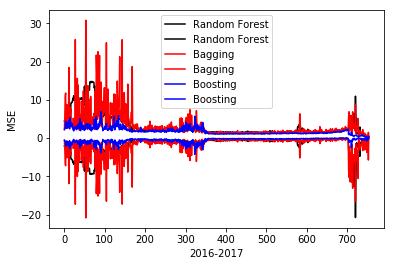

In [137]:
plt.plot(model1metrics, color= 'black', label= 'Random Forest')
plt.plot(model2metrics, color= 'r', label= 'Bagging')
plt.plot(model3metrics, color= 'b', label= 'Boosting')

plt.xlabel('2016-2017')
plt.ylabel('MSE')
plt.legend()
plt.show()

No handles with labels found to put in legend.


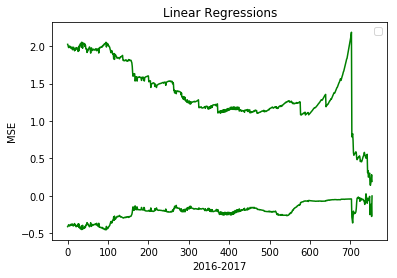

In [136]:

plt.plot(model4metrics, color= 'g')

plt.xlabel('2016-2017')
plt.ylabel('MSE')
plt.title('Linear Regressions')
plt.legend()
plt.show()

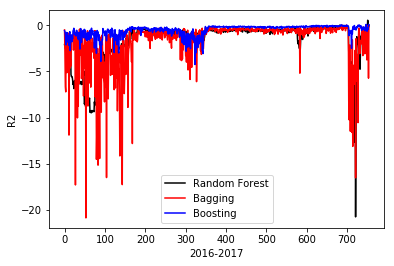

In [141]:
plt.plot(r2_rf, color= 'black', label= 'Random Forest')
plt.plot(r2_bagging, color= 'r', label= 'Bagging')
plt.plot(r2_boosting, color= 'b', label= 'Boosting')

plt.xlabel('2016-2017')
plt.ylabel('R2')
#plt.title('R2')
plt.legend()
plt.show()

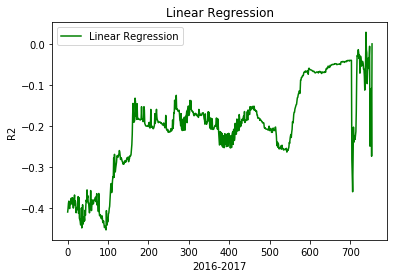

In [140]:
plt.plot(r2_lr, color= 'g', label= 'Linear Regression')

plt.xlabel('2016-2017')
plt.ylabel('R2')
plt.title('Linear Regression')
plt.legend()
plt.show()

#### Sam/Jonathan New Code

In [109]:
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LinearRegression

###########################################################################
# predict = []
# actual = []
# for count in range(1,500):
#     X_train_i = X_train_all.iloc[0:(3454+count-1), :]
#     y_train_i = y_train_all.iloc[0:(3454+count-1)]
     
#     X_val_i = X_train_all.iloc[(3454+count),:].reshape(1,-1)
#     y_val_i = y_train_all.iloc[(3454+count)]
        
# #     rf = RandomForestRegressor(random_state = 0)
# #     rf.fit(X_train_i, y_train_i)
#     model = BayesianRidge(fit_intercept = True)
#     model.fit(X_train_i, y_train_i)
    
#     predict.append(model.predict(X_val_i)[0])
#     actual.append(y_val_i) 
###########################################################################


predict = []
actual = []

# Set the number of predictions we want to make
trainSize = 3950 # 3316 # chosen arbitrarily out of 3979
numPreds = X_train_all.shape[0] - trainSize # Number of Predictions = numRows - training size

# for each prediction
for i in range(numPreds - 2): # i = 0,1,2,..., 28
    trainSize += 1
    
    # set temp train/test sets
    # do the split for train, Take row 0 to last element of train index
    X_train_i = X_train_all.iloc[0:trainSize,:]
    y_train_i = y[X_train_i.index]
    
    # Validation Set
    # do the split for validation, Take first element of test index to last element of test index
    #X_val_i = X_train_all.iloc[trainSize:,:]
    #y_val_i = y[X_val_i.index]
    
    # Validation Point
    X_val_i = X_train_all.iloc[trainSize+1,:]
    y_val_i = y.iloc[trainSize]
#     print(X_val_i)
#     print(y_val_i)
#     print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    

    # random forest regression based on default parameter
    rf = RandomForestRegressor(random_state = 0)
    rf.fit(X_train_i, y_train_i)
    rf.predict(X_val_i)
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~: ", i)

    #model1metrics.append([mean_squared_error(y_val, rf.predict(X_val)),r2_score(y_val, rf.predict(X_val))])
    




/Users/YoungFreeesh/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ValueError: Expected 2D array, got 1D array instead:
array=[ 1.52449997e+02  1.51199997e+02  1.51300003e+02  3.75620000e+06
  1.45374405e+02  9.56747830e-01  1.03375530e+00 -1.00579485e-01
  1.37319469e+00 -1.20221996e+00  3.30199748e-01  1.22515261e+00
  5.52848756e-01  2.63114840e-01  1.44147186e+02  1.43510269e+02
 -5.31631529e-01  8.16734886e+00  4.81605791e-02  6.76776707e-01
  1.49674805e+02  1.48149597e+02  1.46899597e+02  1.50924805e+02
  1.48424805e+02  1.49399597e+02  1.45649597e+02 -4.66047382e+00
 -3.97722125e+00  1.58719035e-04 -1.47963792e-01 -2.93338746e-01
  1.45374954e-01  2.65969906e+01 -4.31568623e-02  7.42767155e-01
  2.02787612e-02  5.59358750e+05  5.00000000e-01  2.26285723e+04
 -2.74321844e+05 -7.71346009e-08  1.09925938e+00  1.47977524e+02
  1.49630386e+02  1.46324677e+02  2.13160902e-01  1.63300018e+01].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [85]:
predict

[array([ 0.49410248, -0.48987843,  0.06448298,  1.07046489,  0.05344468,
         0.91970306,  0.97300238,  0.8059751 , -0.28112458,  0.10812025,
         0.10907936,  1.85424015,  1.09983987,  0.55189989,  1.11698835,
         0.91529398,  0.57558763,  0.80632167,  1.694202  ,  1.27353165,
         1.73330443,  0.42349594, -0.37934653, -0.10316982,  1.15547407,
         0.58834873,  1.16518353,  1.46586894]),
 array([-0.5932376 ,  0.32315923,  1.03006746,  0.24794231,  0.81149558,
         0.96739963,  0.73736105, -0.32023423,  0.07060223,  0.68874746,
         1.84128546,  1.25162131,  0.5833257 ,  1.12264801,  0.68062264,
         0.70179233,  0.8574795 ,  1.64138631,  1.68009297,  1.83276308,
         0.49456481, -0.41270645, -0.24489594,  1.15539677,  0.57607978,
         1.31055795,  1.61751521]),
 array([ 0.12382745,  0.88408262,  0.21058095,  0.65256717,  0.96980159,
        -0.19090647, -0.17599517,  0.10285026,  0.75550208,  1.51298377,
         1.36751004,  1.14714603,  1.99

#### Sams Code

In [ ]:
# Initialize empty arrays
trainsamples  = [] # [664, 1327, 1990, 2653, 3316] # sizes of training samples
model1metrics = [] # Random Forest
model2metrics = [] # Bagging
model3metrics = [] # Boosting
model4metrics = [] # Linear Regression


### Random Forest - Train-Validate model
# in this case we can consider validation set as a test set

# Set the number of predictions we want to make
# Note - Num Predictions == Num models we'll need to train
trainSize = 3950 # 3316 # chosen arbitrarily
numPreds = X_train_all.shape[0] - trainSize # Number of Predictions = numRows - training size

# drop date
# X_train_all_temp = X_train_all.copy(deep=True)
# X_train_all_temp.drop(['Date'], axis = 1, inplace = True) # expensive so just do once here

# for each prediction
for i in range(numPreds): # i = 0,1,2,...
    trainSize += 1
    # set temp train/test sets
    
    # do the split for train, Take row 0 to last element of train index
    X_train = X_train_all_temp.loc[0:trainSize,:]
    y_train = y[X_train.index]
    #y_train = y_train.iloc[1:] # 
    
    # do the split for validation, Take first element of test index to last element of test index
    X_val = X_train_all_temp.loc[trainSize:,:]
    y_val = y[X_val.index]
    
    trainsamples.append(X_train.shape[0])

    # random forest regression based on default parameter
    #rf = RandomForestRegressor(random_state = 0)
    #rf.fit(X_train, y_train)
    #rf.predict(X_val)
    #model1metrics.append([mean_squared_error(y_val, rf.predict(X_val)),r2_score(y_val, rf.predict(X_val))])
    




/Users/YoungFreeesh/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/YoungFreeesh/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/YoungFreeesh/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/YoungFreeesh/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/YoungFree

In [136]:
X_val.head()

,Date,High,Low,Open,Volume,Close,Today,lag1,lag2,lag3,...,MFI_14,OBV_14,Force_14,EoM_14,CCI_14,KelChM_14,KelChU_14,KelChD_14,Ultimate_Osc,Donchian_14
3969,2017-12-15,153.800003,152.029999,153.610001,11279900,145.900604,-0.974037,0.058476,-1.805529,0.855812,...,0.571429,1.085450e+06,3.933165e+06,2.164210e-08,-1.347368,152.202559,153.968988,150.436130,-0.091807,6.719986
3970,2017-12-18,154.179993,153.210007,153.589996,5092800,146.694687,0.544263,-0.974037,0.058476,-1.805529,...,0.571429,1.165386e+06,9.207610e+05,2.650518e-08,-0.851382,152.287863,154.035720,150.540006,0.013931,7.399994
3971,2017-12-19,154.169998,153.089996,154.050003,4116400,146.599014,-0.065219,0.544263,-0.974037,0.058476,...,0.500000,5.071643e+05,3.007334e+05,1.368730e-08,-0.976770,152.315812,154.037955,150.593669,-0.103907,8.199997
3972,2017-12-20,153.889999,152.779999,153.649994,3785700,146.331131,-0.182732,-0.065219,0.544263,-0.974037,...,0.428571,-2.275857e+05,2.649600e+06,-4.985668e-09,-1.160609,152.273053,153.979481,150.566624,-0.182840,8.809998
3973,2017-12-21,153.460007,151.490005,153.169998,4153900,144.943878,-0.948023,-0.182732,-0.065219,0.544263,...,0.357143,-9.220000e+05,4.410163e+06,-4.007323e-08,-1.718888,152.127840,153.824269,150.431412,-0.439012,10.589996


In [107]:
y_val.head()
rf.predict(X_val).head()

3316   -0.453896
3317   -0.115463
3318    0.242721
3319    0.161402
3320   -0.241713
Name: Today, dtype: float64

In [112]:
X_train_all
X_train_all.shape[0]

3979

In [117]:
train_index[len(train_index) - 1]

3315

In [157]:
X_val

,High,Low,Open,Volume,Close,Today,lag1,lag2,lag3,lag4,...,MFI_14,OBV_14,Force_14,EoM_14,CCI_14,KelChM_14,KelChU_14,KelChD_14,Ultimate_Osc,Donchian_14
3969,153.800003,152.029999,153.610001,11279900,145.900604,-0.974037,0.058476,-1.805529,0.855812,0.387562,...,0.571429,1.085450e+06,3.933165e+06,2.164210e-08,-1.347368,152.202559,153.968988,150.436130,-0.091807,6.719986
3970,154.179993,153.210007,153.589996,5092800,146.694687,0.544263,-0.974037,0.058476,-1.805529,0.855812,...,0.571429,1.165386e+06,9.207610e+05,2.650518e-08,-0.851382,152.287863,154.035720,150.540006,0.013931,7.399994
3971,154.169998,153.089996,154.050003,4116400,146.599014,-0.065219,0.544263,-0.974037,0.058476,-1.805529,...,0.500000,5.071643e+05,3.007334e+05,1.368730e-08,-0.976770,152.315812,154.037955,150.593669,-0.103907,8.199997
3972,153.889999,152.779999,153.649994,3785700,146.331131,-0.182732,-0.065219,0.544263,-0.974037,0.058476,...,0.428571,-2.275857e+05,2.649600e+06,-4.985668e-09,-1.160609,152.273053,153.979481,150.566624,-0.182840,8.809998
3973,153.460007,151.490005,153.169998,4153900,144.943878,-0.948023,-0.182732,-0.065219,0.544263,-0.974037,...,0.357143,-9.220000e+05,4.410163e+06,-4.007323e-08,-1.718888,152.127840,153.824269,150.431412,-0.439012,10.589996
3974,153.000000,151.500000,151.820007,2990600,145.900604,0.660067,-0.948023,-0.182732,-0.065219,0.544263,...,0.357143,-1.041550e+06,6.341039e+06,-1.003256e-07,-1.373146,151.862158,153.542159,150.182158,-0.155801,10.589996
3975,153.860001,152.500000,152.509995,2479000,146.216324,0.216394,0.660067,-0.948023,-0.182732,-0.065219,...,0.428571,-5.024786e+05,6.241988e+06,-5.734949e-08,-0.683644,151.684278,153.314278,150.054279,-0.112590,9.300003
3976,153.179993,152.610001,152.949997,2149300,146.503357,0.196307,0.216394,0.660067,-0.948023,-0.182732,...,0.428571,-1.053357e+05,1.170610e+06,-3.799101e-08,-0.657686,151.554563,153.073133,150.035993,0.054648,7.970001
3977,154.119995,153.199997,153.199997,2687600,147.373947,0.594246,0.196307,0.216394,0.660067,-0.948023,...,0.500000,3.560000e+05,-4.871749e+05,1.001581e-08,0.007211,151.555983,153.055267,150.056699,0.082128,6.900009
3978,154.720001,153.419998,154.169998,3327100,146.780777,-0.402493,0.594246,0.196307,0.216394,0.660067,...,0.500000,-1.331000e+05,2.569298e+05,8.395639e-09,0.106578,151.513843,153.000271,150.027416,0.008701,5.600006


In [134]:
trainSize

216194